In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy


## Define some variables and set constants

In [184]:
num_input_parameters = 6
num_output_parameters = 1
learning_rate = 0.1
num_steps = 100
batch_size = 10
num_neurons = 6

#initial values
S0 = 1
V0 = 0.2
r = 0.25

#bounds for a,b,c,rho,T,K
bounds = np.array([[1,3],[0.1,0.6],[0,0.1],[0,1],[1,2],[0.6,1.3]])

scaler = MinMaxScaler()

X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

## Next Batch using Heston "closed form"

In [185]:
#input:
#output: Call option price with strike K and Maturity T
def heston_closed(a,b,c,T,K,rho,V0,S0,r=0):
    
    def char_f(w,a,b,c,T,K,rho,V0,S0,r):
        alpha = -0.5*w*(w+complex(0,1))
        beta = a - rho*c*w*complex(0,1)
        gamma = c*c/2
        h = cmath.sqrt(beta*beta-4*alpha*gamma)
        rplus = (beta + h)/c/c
        rminus = (beta - h)/c/c
        g = rminus/rplus
        D =  rminus*(1-cmath.exp(-h*T))/(1-g*cmath.exp(-h*T))
        C = a*(rminus*T-2/c/c*cmath.log((1-g*cmath.exp(-h*T))/(1-g)))
        return cmath.exp(C*b+D*V0+complex(0,1)*w*cmath.log(S0*cmath.exp(r*T)))

    def integrand1(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w-i,a,b,c,T,K,rho,V0,S0,r)/i/w/char_f(-i,a,b,c,T,K,rho,V0,S0,r)).real
    
    def integrand2(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w,a,b,c,T,K,rho,V0,S0,r)/i/w).real
    
    pi1 = 0.5 + quad(integrand1,0,np.inf)[0]/np.pi
    pi2 = 0.5 + quad(integrand2,0,np.inf)[0]/np.pi
    
    return (S0*pi1 + cmath.exp(-r*T)*K*pi2).real

In [186]:
#input: batch_size, bounds for a,b,c,rho in that order 
#output: X_batch,y_batch
def next_batch_heston_train(batch_size,bounds):
    #for heston X contains values for a,b,c,rho,T,K and S0,V0 are kept fixed for now
    X = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))
    
    X[:,0] = uniform.rvs(size=batch_size)*(bounds[0][1]-bounds[0][0]) + bounds[0][0]#a
    X[:,1] = uniform.rvs(size=batch_size)*(bounds[1][1]-bounds[1][0]) + bounds[1][0] #b
    X[:,2] = uniform.rvs(size=batch_size)*(bounds[2][1]-bounds[2][0]) + bounds[2][0] #c
    X[:,3] = uniform.rvs(size=batch_size)*(bounds[3][1]-bounds[3][0]) + bounds[3][0] #rho
    X[:,4] = uniform.rvs(size=batch_size)*(bounds[4][1]-bounds[4][0]) + bounds[4][0] #maturities T 
    X[:,5] = uniform.rvs(size=batch_size)*(bounds[5][1]-bounds[5][0]) + bounds[5][0] #strikes K

    
    for i in range(batch_size):
        y[i,0] = heston_closed(X[i,0],X[i,1],X[i,2],X[i,4],X[i,5],X[i,3],V0,S0,r)
    
    #X = scaler.fit_transform(X)
    #y = scaler.fit_transform(y)
    
    return X,y

## Next Batch using Euler Maruyama MC

In [187]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

In [188]:
def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

In [189]:
#work in progress
def heston(a,b,c,T,W,Z,V0,S0):
    #assert(2*a*b > c*c) 
    
    def mu2(V,i,k):
        return np.multiply(a,(b-V))
    
    def sigma2(V,i,k):
        return np.multiply(c,np.sqrt(np.maximum(0.0,V)))
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(np.sqrt(np.maximum(0.0,V[i,k])),S)
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

In [190]:
#input: batch_size, bounds for a,b,c,rho in that order 
#output: X_batch,y_batch
def next_batch_heston_EM_train(batch_size,bounds):
    X = np.zeros((batch_size,num_input_parameters))
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled = uniform.rvs(size=(batch_size,num_input_parameters))
    
    X = reverse_transform_tuple(X_scaled,num_input_parameters)

    n = 500
    dim = 100
        
    for i in range(batch_size):
        W,Z = corr_brownian_motion(n,X[i,4],dim,X[i,3])
        S,V = heston(X[i,0],X[i,1],X[i,2],X[i,4],W,Z,V0,S0)
        S_T = S[:,n]
        
        y[i,0] = np.exp(-r*X[i,4])*np.mean(np.maximum(S_T-X[i,5],np.zeros(dim)))
    
    #X = scaler.fit_transform(X)
    #y = scaler.fit_transform(y)
    
    return X_scaled,y

In [191]:
def reverse_transform(X,n):
    res = np.zeros(len(X))
    for i in range(n):
        res[i] = X[i]*(bounds[i][1]-bounds[i][0]) + bounds[i][0]
    return res

def reverse_transform_tuple(X,n):
    res = np.zeros(X.shape)
    for i in range(n):
        res[:,i] = X[:,i]*(bounds[i][1]-bounds[i][0]) + bounds[i][0]
    return res

In [192]:
def transform(X,n):
    res = np.zeros(len(X))
    for i in range(n):
        res[i] = (X[i] - bounds[i][0])/(bounds[i][1]-bounds[i][0])
    return res

def transform_tuple(X,n):
    res = np.zeros(X.shape)
    for i in range(n):
        res[:,i] = (X[:,i] - bounds[i][0])/(bounds[i][1]-bounds[i][0])
    return res

## Design Neural Network and Train

In [193]:
#Layers
num_layers = 3
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
hidden2 = fully_connected(hidden1, num_neurons, activation_fn=tf.nn.elu)
hidden3 = fully_connected(hidden2, num_neurons, activation_fn=tf.nn.elu)

outputs = fully_connected(hidden3, num_output_parameters, activation_fn=None)

In [194]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

In [195]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [196]:
init = tf.global_variables_initializer()

In [197]:
saver = tf.train.Saver()

In [199]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        #X_batch,Y_batch = next_batch_heston_train(batch_size,bounds)
        X_batch,Y_batch = next_batch_heston_EM_train(batch_size,bounds)

        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 5 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    #saver.save(sess, "./models/heston_closed_nn")
    saver.save(sess, "./models/heston_closed_EM_nn")

0 	RMSE: 1.5151359
5 	RMSE: 0.33046454
10 	RMSE: 0.09543373
15 	RMSE: 0.08138595
20 	RMSE: 0.039936956
25 	RMSE: 0.024469431
30 	RMSE: 0.09638455
35 	RMSE: 0.060724646
40 	RMSE: 0.046200167
45 	RMSE: 0.028411422
50 	RMSE: 0.061275415
55 	RMSE: 0.037848998
60 	RMSE: 0.028508406
65 	RMSE: 0.020021426
70 	RMSE: 0.057594318
75 	RMSE: 0.08038608
80 	RMSE: 0.02813054
85 	RMSE: 0.096471146
90 	RMSE: 0.041937016
95 	RMSE: 0.14082523
100 	RMSE: 0.08570598
105 	RMSE: 0.039034896
110 	RMSE: 0.020854834
115 	RMSE: 0.041152745


KeyboardInterrupt: 

## Optimze for Market Parameter

In [146]:
theta_true = [1.1,0.2,0.25,0.4]
T = [1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.6,1.7]
K = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2]

In [147]:
def NNprediction(x):
    x = transform(x.T,4)
    tmp = np.zeros((1,6))
    tmp[0,:] = x

    return sess.run(outputs,feed_dict={X: tmp})

def NNgradientpred(x):
    x = np.asarray(x)
    x = transform(x.T,4)
    tmp = np.zeros((1,6))
    tmp[0,:] = x
    num_parameters = num_input_parameters-2
    grad = np.zeros(num_parameters)
    
    delta = 0.00000001
    for i in range(num_parameters):
        h = np.zeros(tmp.shape)
        h[0,i] = delta
        
        #two point gradient
        #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

        #four point gradient
        grad[i] = (-sess.run(outputs,feed_dict={X: tmp+2*h})+8*sess.run(outputs,feed_dict={X: tmp+h})-8*sess.run(outputs,feed_dict={X: tmp-h}) +sess.run(outputs,feed_dict={X: tmp-2*h}))/12/delta

    return grad

In [148]:
#input: theta in order a,b,c,rho
def CostFuncLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]

    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]
   
    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_


    n = 100
    dim = 10
    W,Z = corr_brownian_motion(n,T_,dim,theta_true[3])
    S,V = heston(theta_true[0],theta_true[1],theta_true[2],K_,W,Z,V0,S0)
    S_T = S[:,n]
        
    heston_= np.exp(-r*T_)*np.mean(np.maximum(S_T-K_,np.zeros(dim)))

    return np.abs(NNprediction(x)-heston_)[0,:]


def JacobianLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]
    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]

    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_

    return NNgradientpred(x).T

In [149]:
with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn")   

    init = [bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]]
    init_best = init
    
    cost_old = 1000000
    n = 4
    for a in range(n):
        init_new = [bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]]
        init_new[0] += 1/(n+1)*(bounds[0,1]-bounds[0,0])
        for b in range(n):
            init_new[1] += 1/(n+1)*(bounds[1,1]-bounds[1,0])
            init_new[2] = bounds[2,0]
            init_new[3] = bounds[3,0]
            for c in range(n):
                init_new[2] += 1/(n+1)*(bounds[2,1]-bounds[2,0])
                init_new[3] = bounds[3,0]
                for d in range(n):
                    init_new[3] += 1/(n+1)*(bounds[3,1]-bounds[3,0])
                    
                    cost_new = CostFuncLS(init_new,0,0)
                    if cost_new < cost_old:
                        init_best = init_new 
                    cost_old = cost_new

    init = init_best
print(init)

INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn
[1.4, 0.5, 0.08000000000000002, 0.8]


In [150]:
init_transformed = transform(init,4)
print(init_transformed)

[0.2 0.8 0.8 0.8]


In [151]:
bnds = ([bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]],[bounds[0,1],bounds[1,1],bounds[2,1],bounds[3,1]])


with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn")   
 
    Theta = np.zeros((len(T),len(K),len(init)))
    for i in range(len(T)):
        for j in range(len(K)):
            I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,args=(i,j),verbose=0)
            Theta[i,j,:] = I.x
          

INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn


In [152]:
#print(Theta)

In [153]:
print("Mean of Predicted Theta: ",np.mean(np.mean(Theta,axis=0),axis=0))
print("True Theata: ",theta_true) 

Mean of Predicted Theta:  [1.4  0.5  0.08 0.8 ]
True Theata:  [1.1, 0.2, 0.25, 0.4]


In [154]:
RMSE = 0
price_true = np.zeros((len(T),len(K)))
price_opt_params = np.zeros((len(T),len(K)))
for i in range(len(T)):
    for j in range(len(K)):
        #price_true = heston_closed(theta_true[0],theta_true[1],theta_true[2],T[i],K[j],theta_true[3],V0,S0)
        n = 100
        dim = 20
        W,Z = corr_brownian_motion(n,T[i],dim,theta_true[3])
        S,V = heston(theta_true[0],theta_true[1],theta_true[2],T[i],W,Z,V0,S0)
        S_T = S[:,n]
        price_true[i,j] = np.exp(-r*T[i])*np.mean(np.maximum(S_T-K[j],np.zeros(dim)))
        
        #price_opt_params = heston_closed(Theta[i,j,0],Theta[i,j,1],Theta[i,j,2],T[i],K[j],Theta[i,j,3],V0,S0)
        W,Z = corr_brownian_motion(n,T[i],dim,Theta[i,j,3])
        S,V = heston(Theta[i,j,0],Theta[i,j,1],Theta[i,j,2],T[i],W,Z,V0,S0)
        S_T = S[:,n]
        price_opt_params[i,j] = np.exp(-r*T[i])*np.mean(np.maximum(S_T-K[j],np.zeros(dim)))
        RMSE += np.power(price_true[i,j]-price_opt_params[i,j],2)
RMSE = np.sqrt(RMSE/(len(T)*len(K)))
print("RMSE: ", RMSE)

RMSE:  0.013122868674034557


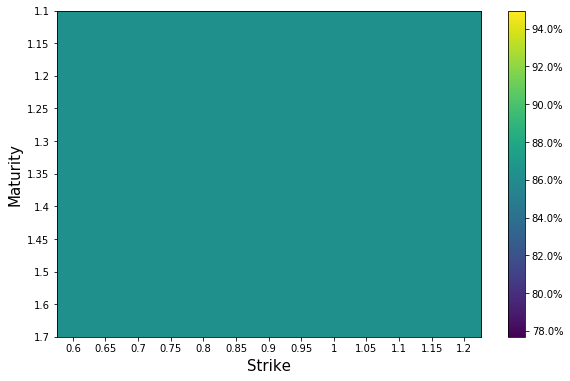

In [155]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


err = np.mean((100*np.abs((theta_true-Theta)/theta_true)),axis=2)
#print("Relative error in percent: ",err)
plt.figure(1,figsize=(10,6))
ax=plt.subplot(1,1,1)
plt.imshow(err.reshape(len(T),len(K)))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_yticks(np.linspace(0,len(T)-1,len(T)))
ax.set_yticklabels(T)
ax.set_xticks(np.linspace(0,len(K)-1,len(K)))
ax.set_xticklabels(K)

plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)



plt.show()

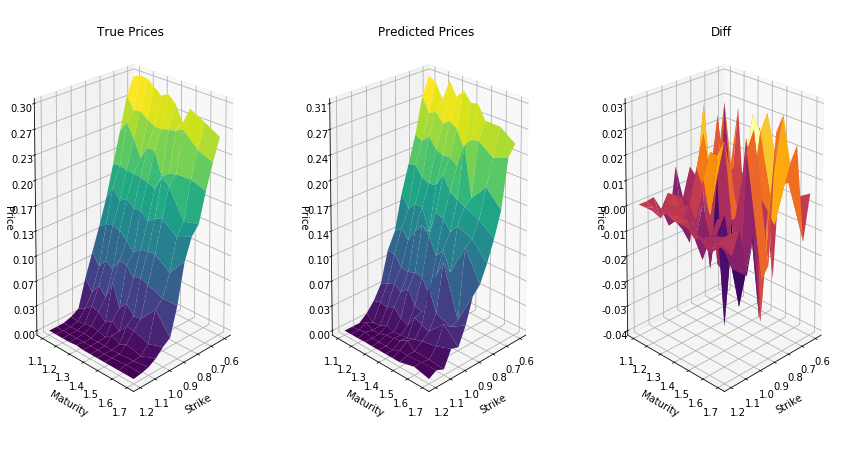

In [156]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(15, 8))

T_ = np.zeros((len(T),len(K)))
K_ = np.zeros((len(T),len(K)))
for i in range(len(K)):
    for j in range(len(T)):
        T_[j,i] = T[j]
for j in range(len(T)):   
    for i in range(len(K)):
        K_[j,i] = K[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=price_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=price_opt_params, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=price_true-price_opt_params, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price')
ax3.set_title('Diff')
ax3.view_init(15, 45)




plt.show()

In [157]:
import time
n1 = 1000
dim1 = 1000

In [158]:
%timeit W1,Z1 = corr_brownian_motion(n1,T[0],dim1,theta_true[3])
W1,Z1 = corr_brownian_motion(n1,T[0],dim1,theta_true[3])

79.6 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [159]:
%timeit S,V = heston(theta_true[0],theta_true[1],theta_true[2],T[0],W1,Z1,V0,S0)
S,V = heston(theta_true[0],theta_true[1],theta_true[2],T[0],W1,Z1,V0,S0)

19.1 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
%timeit S_T = S[:,n]
S_T = S[:,n]

261 ns ± 1.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [166]:
%timeit P = np.exp(-r*T[0])*np.mean(np.maximum(S_T-K[0],np.zeros(dim1)))

20 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [167]:
with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn") 
    %timeit CostFuncLS(theta_true,0,0)

INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn
19.8 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [176]:
NNweights = []
with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn") 
    vars = [v for v in tf.trainable_variables()]
    vars_vals = sess.run(vars)
    for var, val in zip(vars, vars_vals):
        print("var: {}, value: {}".format(var.name, val))   

    



INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn
var: fully_connected/weights:0, value: [[-0.30072027  0.42695934 -0.11230654 -0.5760876   0.16876423 -0.658502  ]
 [-0.35274652 -0.2999146   0.5011187  -0.6222078   0.69044524  0.22377008]
 [-0.02795231  0.4185384   0.21717948  0.63999504 -0.2825818   0.61732286]
 [-0.25743464  0.1587112  -0.44442976 -0.40564418 -0.59621066  0.25246668]
 [-0.13102174 -0.30812582 -0.42035446  0.54659456 -0.4785151  -0.3978669 ]
 [ 0.29102498  0.50298995  0.6974315   0.5500757   0.34200233 -0.02421421]]
var: fully_connected/biases:0, value: [0. 0. 0. 0. 0. 0.]
var: fully_connected_1/weights:0, value: [[ 0.03197885 -0.6771653  -0.06901109 -0.6545237   0.18176788  0.7069883 ]
 [-0.66250545  0.4787349  -0.08798474 -0.56089985  0.06310511  0.5392969 ]
 [-0.5679525  -0.5391873  -0.04226923 -0.03500581  0.41166633  0.5169789 ]
 [ 0.16315734  0.10664499 -0.4791451   0.15867716 -0.70027226  0.6174113 ]
 [ 0.7046122  -0.1979577   0.12158895  0

In [183]:
print(np.ndarray(vars_vals).shape)

ValueError: maximum supported dimension for an ndarray is 32, found 54